In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from scipy.signal import fftconvolve
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path

In [2]:
yellow = "#ffb000"
blue = "#648fff"
red = "#dc267f"
purple = "#785ef0"
green = "#2AC759"

In [3]:
# https://stats.stackexchange.com/questions/64680/how-to-determine-quantiles-isolines-of-a-multivariate-normal-distribution
def quantile2sigma(value, q):
    c = - 2 * np.log(1 - q)

    sigma = value / np.sqrt(c)

    return sigma

def sigma2quantile(sigma, q):
    c = - 2 * np.log(1 - q)

    value = np.sqrt(c) * sigma

    return value

In [4]:
d_board = 451e-3 # (m)
d_bull = 31.8e-3 # (m)
d_dbull = 12.7e-3 # (m)
d_triple = 214e-3 # (m)
d_double = 340e-3 # (m)
w_ring = 8e-3 # (m)
# w_wire = 1.5e-3 # (m)
alpha = 18 # (deg)

dx = 1e-3 # (m)
dy = 1e-3 # (m)
x = np.arange(- d_board / 2, d_board / 2, dx)
y = np.arange(- d_board / 2, d_board / 2, dy)

x_g, y_g = np.meshgrid(x, y, indexing="xy")

r_g = np.sqrt(x_g ** 2 + y_g ** 2)
phi_g = 180 / np.pi * np.arctan2(y_g, x_g)
phi_g[phi_g < 0] += 360

In [5]:
factors = np.ones_like(r_g)
points = 0 * np.ones_like(phi_g)

points[(r_g <= d_dbull / 2)] = 50
points[(r_g > d_dbull / 2) & (r_g <= d_bull / 2)] = 25

points[(r_g > d_bull / 2) & ((phi_g > 360 - alpha / 2) | (phi_g <= alpha / 2))] = 6
points[(r_g > d_bull / 2) & (phi_g > alpha / 2) & (phi_g <= 3 * alpha / 2)] = 13
points[(r_g > d_bull / 2) & (phi_g > 3 * alpha / 2) & (phi_g <= 5 * alpha / 2)] = 4
points[(r_g > d_bull / 2) & (phi_g > 5 * alpha / 2) & (phi_g <= 7 * alpha / 2)] = 18
points[(r_g > d_bull / 2) & (phi_g > 7 * alpha / 2) & (phi_g <= 9 * alpha / 2)] = 1
points[(r_g > d_bull / 2) & (phi_g > 9 * alpha / 2) & (phi_g <= 11 * alpha / 2)] = 20
points[(r_g > d_bull / 2) & (phi_g > 11 * alpha / 2) & (phi_g <= 13 * alpha / 2)] = 5
points[(r_g > d_bull / 2) & (phi_g > 13 * alpha / 2) & (phi_g <= 15 * alpha / 2)] = 12
points[(r_g > d_bull / 2) & (phi_g > 15 * alpha / 2) & (phi_g <= 17 * alpha / 2)] = 9
points[(r_g > d_bull / 2) & (phi_g > 17 * alpha / 2) & (phi_g <= 19 * alpha / 2)] = 14
points[(r_g > d_bull / 2) & (phi_g > 19 * alpha / 2) & (phi_g <= 21 * alpha / 2)] = 11
points[(r_g > d_bull / 2) & (phi_g > 21 * alpha / 2) & (phi_g <= 23 * alpha / 2)] = 8
points[(r_g > d_bull / 2) & (phi_g > 23 * alpha / 2) & (phi_g <= 25 * alpha / 2)] = 16
points[(r_g > d_bull / 2) & (phi_g > 25 * alpha / 2) & (phi_g <= 27 * alpha / 2)] = 7
points[(r_g > d_bull / 2) & (phi_g > 27 * alpha / 2) & (phi_g <= 29 * alpha / 2)] = 19
points[(r_g > d_bull / 2) & (phi_g > 29 * alpha / 2) & (phi_g <= 31 * alpha / 2)] = 3
points[(r_g > d_bull / 2) & (phi_g > 31 * alpha / 2) & (phi_g <= 33 * alpha / 2)] = 17
points[(r_g > d_bull / 2) & (phi_g > 33 * alpha / 2) & (phi_g <= 35 * alpha / 2)] = 2
points[(r_g > d_bull / 2) & (phi_g > 35 * alpha / 2) & (phi_g <= 37 * alpha / 2)] = 15
points[(r_g > d_bull / 2) & (phi_g > 37 * alpha / 2) & (phi_g <= 39 * alpha / 2)] = 10

factors[r_g > d_double / 2] = 0
factors[(r_g <= d_double / 2) & (r_g > d_double / 2 - w_ring)] = 2
factors[(r_g <= d_triple / 2) & (r_g > d_triple / 2 - w_ring)] = 3

points *= factors

In [6]:
plt.figure(figsize=(4, 4))

plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")

points_order = (6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10)
for ii in range(len(points_order)):
    plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
             points_order[ii], 
             horizontalalignment="center",
             verticalalignment="center",
             fontsize=12, 
             color=(1, 1, 1))
    
plt.gca().axis("off")
plt.gca().set_aspect(1)

plt.savefig(Path("..", "content", "img", "dartboard_points.svg"), dpi=600)
plt.close()

In [7]:
area_50 = 1e-4 * np.logspace(0, 3, 400) # (m^2)
scales = np.array([1/3, 2/3, 3/3, 3/2, 3/1])

axis_x_50 = np.sqrt(area_50[:, None] / (np.pi * scales[None, :])) # (m)
axis_y_50 = scales[None, :] * axis_x_50 # (m)

mu_x, mu_y = (0, 0) # (m)
sigma_x, sigma_y = (quantile2sigma(axis_x_50, 0.5), quantile2sigma(axis_y_50, 0.5)) # (m)
cov_x, cov_y = (sigma_x ** 2, sigma_y ** 2)
n_sigma = 3

axis_x_95, axis_y_95 = (sigma2quantile(sigma_x, 0.95), sigma2quantile(sigma_y, 0.95)) # (m)

points_expected = np.zeros((*np.shape(x_g), len(area_50), len(scales)), dtype=float)

r_t20 = d_triple / 2 - w_ring / 2
phi_t20 = 90
x_t20 = r_t20 * np.cos(np.pi * phi_t20 / 180)
y_t20 = r_t20 * np.sin(np.pi * phi_t20 / 180)
points_expected_t20 = np.empty((len(area_50), len(scales)), dtype=float)

r_be = 0
phi_be = 0
x_be = r_be * np.cos(np.pi * phi_be / 180)
y_be = r_be * np.sin(np.pi * phi_be / 180)
points_expected_be = np.empty((len(area_50), len(scales)), dtype=float)

x_opt = np.empty((len(area_50), len(scales)), dtype=float)
y_opt = np.empty((len(area_50), len(scales)), dtype=float)
points_expected_opt = np.empty((len(area_50), len(scales)), dtype=float)

for ii in range(len(area_50)):
    for jj in range(len(scales)):
        x_psf = np.arange(-n_sigma * sigma_x[ii, jj], n_sigma * sigma_x[ii, jj], dx)
        y_psf = np.arange(-n_sigma * sigma_y[ii, jj], n_sigma * sigma_y[ii, jj], dy)
        x_psf, y_psf = np.meshgrid(x_psf, y_psf, indexing="xy")
        r_psf = np.stack((x_psf, y_psf), axis=2)
        
        psf = multivariate_normal(mean=(mu_x, mu_y), cov=(cov_x[ii, jj], cov_y[ii, jj])).pdf(r_psf)
        
        points_expected[:, :, ii, jj] = fftconvolve(points, psf, mode="same")
    
        points_expected_t20[ii, jj] = RegularGridInterpolator((x, y), points_expected[:, :, ii, jj].T)((x_t20, y_t20))
        points_expected_be[ii, jj] = RegularGridInterpolator((x, y), points_expected[:, :, ii, jj].T)((x_be, y_be))
        
        idx_opt = np.unravel_index(np.argmax(points_expected[:, :, ii, jj]), np.shape(points_expected[:, :, ii, jj]))    
        points_expected_opt[ii, jj] = points_expected[:, :, ii, jj][idx_opt]
        x_opt[ii, jj] = x_g[idx_opt]
        y_opt[ii, jj] = y_g[idx_opt]

In [8]:
for jj in range(len(scales)):
    plt.figure(figsize=(4, 4))
    
    plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma", zorder=5)
    plt.scatter(x_opt[:, jj], y_opt[:, jj], c=np.log10(area_50), s=20, cmap="turbo", zorder=15)
           
    plt.text(0.05, 0.95, f"${100 * scales[jj]:.0f}\%$", 
             horizontalalignment="left",
             verticalalignment="top",
             color=(1, 1, 1),
             fontsize=12,
             transform=plt.gca().transAxes,
             zorder=10)
    
    for ii in range(len(points_order)):
        plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
                 points_order[ii], 
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=12, 
                 color=(1, 1, 1),
                 zorder=10)

    for ii in range(len(area_50)):
        if np.isin(area_50[ii], [1e-4, 10e-4, 100e-4, 1000e-4]):
            if area_50[ii] == 1e-4:
                skill_color = blue
                z_order = 30
            if area_50[ii] == 10e-4:
                skill_color = green
                z_order = 25
            elif area_50[ii] == 100e-4:
                skill_color = yellow
                z_order = 20
            elif area_50[ii] == 1000e-4:
                skill_color = red
                z_order = 15
                
            offset = 10e-3 # (m)
            plt.scatter(x_opt[ii, jj], y_opt[ii, jj] - offset, 
                        edgecolor=(0, 0, 0), 
                        facecolor=skill_color, 
                        marker="^", 
                        linewidth=1, 
                        s=100, 
                        label=f"${1e4 * area_50[ii]:.0f}\,\\text{{cm}}^2$",
                        zorder=z_order)
            
    plt.gca().axis("off")
    plt.gca().set_aspect(1)
    legend = plt.legend(loc="lower right", fancybox=False, edgecolor=(0, 0, 0), framealpha=0.75, ncol=2)
    legend.set_zorder(10)
    
    plt.savefig(Path("..", "content", "img", f"optimal_strategy_s{100 * scales[jj]:.0f}%.svg", dpi=600, bbox_inches="tight"))
    plt.close()

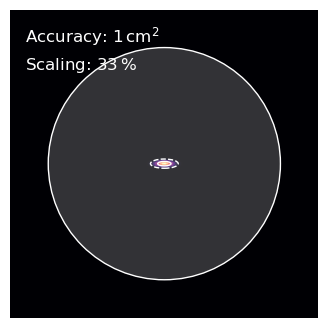

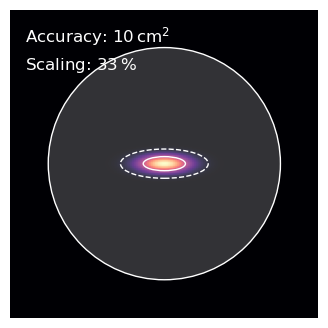

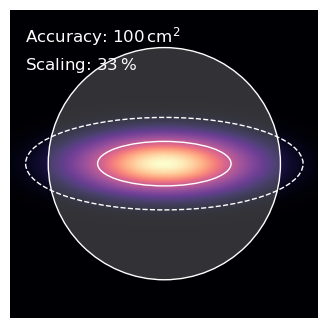

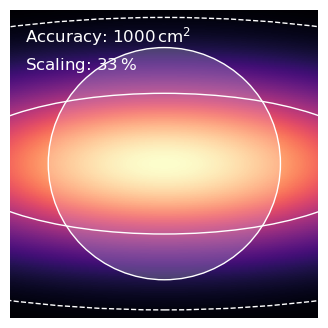

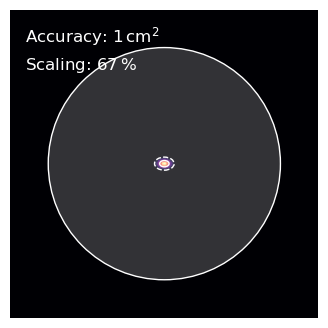

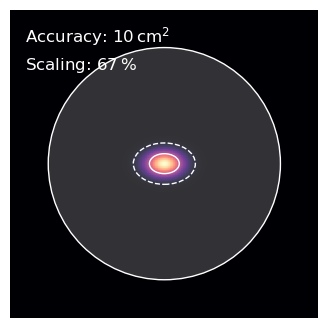

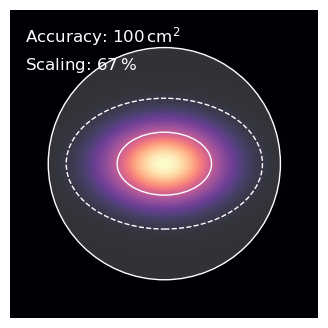

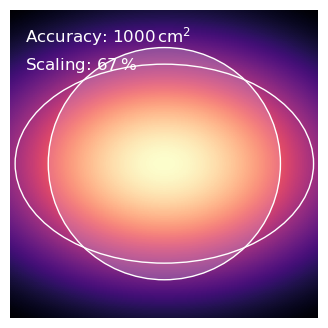

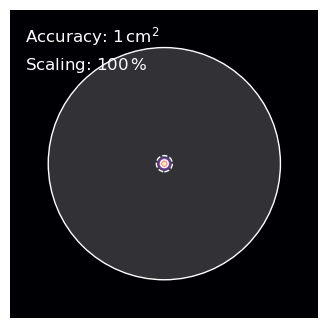

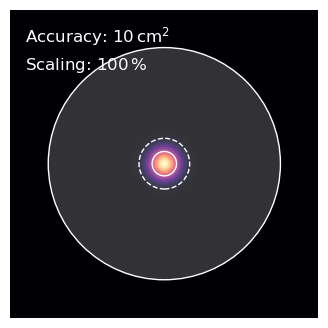

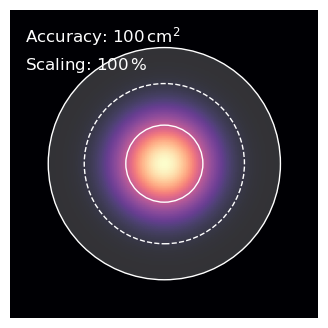

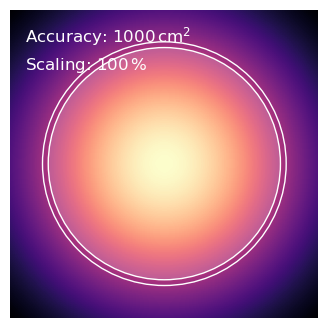

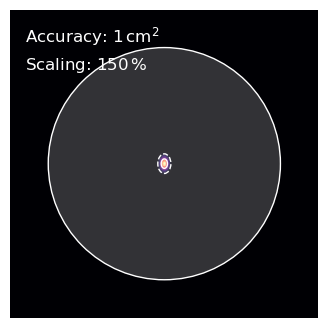

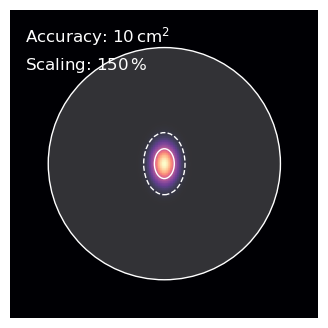

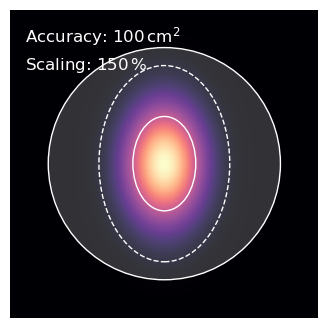

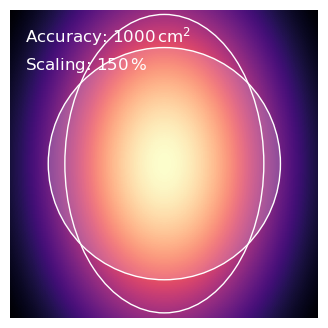

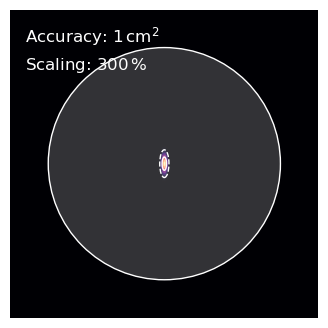

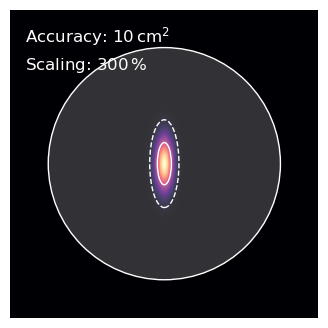

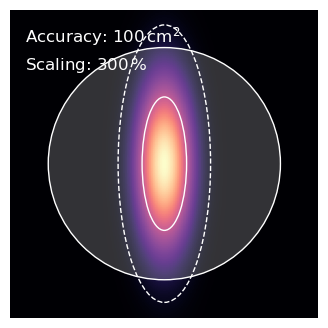

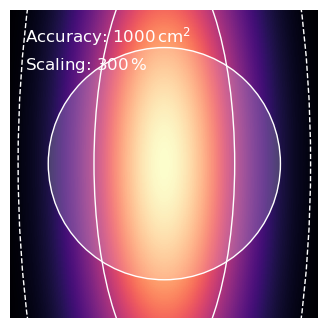

In [22]:
r_psf = np.stack((x_g, y_g), axis=2)

for jj in range(len(scales)):
    for ii in range(len(area_50)):
        if np.isin(area_50[ii], [1e-4, 10e-4, 100e-4, 1000e-4]):
            psf = multivariate_normal(mean=(mu_x, mu_y), cov=(cov_x[ii, jj], cov_y[ii, jj])).pdf(r_psf)
        
            plt.figure(figsize=(4, 4))
            
            plt.pcolormesh(x_g, y_g, psf, rasterized="True", cmap="magma")
        
            ellipse_1 = Ellipse((0, 0), 2 * axis_x_50[ii, jj], 2 * axis_y_50[ii, jj], facecolor="None", edgecolor=(1, 1, 1), zorder=15)
            ellipse_2 = Ellipse((0, 0), 2 * axis_x_95[ii, jj], 2 * axis_y_95[ii, jj], facecolor="None", edgecolor=(1, 1, 1), linestyle="--", zorder=10)
            ellipse_3 = Ellipse((0, 0), d_double, d_double, facecolor="#ffffff33", edgecolor="#ffffff", linestyle="-", zorder=5)
            plt.gca().add_artist(ellipse_1)
            plt.gca().add_artist(ellipse_2)
            plt.gca().add_artist(ellipse_3)
            
            plt.text(0.05, 0.95, f"Accuracy: ${area_50[ii] * 1e4:.0f}\,\\text{{cm}}^2$", 
                     horizontalalignment="left",
                     verticalalignment="top",
                     color=(1, 1, 1),
                     fontsize=12,
                     transform=plt.gca().transAxes)
            plt.text(0.05, 0.85, f"Scaling: ${100 * scales[jj]:.0f}\,\%$", 
                     horizontalalignment="left",
                     verticalalignment="top",
                     color=(1, 1, 1),
                     fontsize=12,
                     transform=plt.gca().transAxes)
        
            plt.gca().axis("off")
            plt.gca().set_aspect(1)
            
            plt.savefig(Path("..", "content", "img", f"psf_acc{1e4 * area_50[ii]:.0f}cm2_s{100 * scales[jj]:.0f}%.svg", dpi=600, bbox_inches="tight"))
            # plt.close()

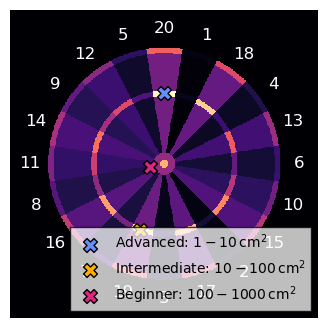

In [10]:
area_skill_50 = (1e-4, 10e-4, 100e-4, 1000e-4)

is_advanced = (area_skill_50[0] <= area_50) & (area_50 < area_skill_50[1])
is_intermediate = (area_skill_50[1] <= area_50) & (area_50 < area_skill_50[2])
is_beginner = (area_skill_50[2] <= area_50) & (area_50 < area_skill_50[3])

optimal_index_advanced = np.argmax(np.mean(points_expected[:, :, is_advanced, :], axis=(2, 3)))
optimal_index_advanced = np.unravel_index(optimal_index_advanced, points_expected.shape[:2])
x_opt_adv = x_g[optimal_index_advanced]
y_opt_adv = y_g[optimal_index_advanced]

optimal_index_intermediate = np.argmax(np.mean(points_expected[:, :, is_intermediate, :], axis=(2, 3)))
optimal_index_intermediate = np.unravel_index(optimal_index_intermediate, points_expected.shape[:2])
x_opt_int = x_g[optimal_index_intermediate]
y_opt_int = y_g[optimal_index_intermediate]

optimal_index_beginner = np.argmax(np.mean(points_expected[:, :, is_beginner, :], axis=(2, 3)))
optimal_index_beginner = np.unravel_index(optimal_index_beginner, points_expected.shape[:2])
x_opt_beg = x_g[optimal_index_beginner]
y_opt_beg = y_g[optimal_index_beginner]

plt.figure(figsize=(4, 4))

plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")

plt.scatter(x_opt_adv, y_opt_adv, color=blue, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Advanced: $1 - 10\,\\text{{cm}}^2$", zorder=10)
plt.scatter(x_opt_int, y_opt_int, color=yellow, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Intermediate: $10 - 100\,\\text{{cm}}^2$", zorder=15)
plt.scatter(x_opt_beg, y_opt_beg, color=red, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Beginner: $100 - 1000\,\\text{{cm}}^2$", zorder=20)

for ii in range(len(points_order)):
    plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
             points_order[ii], 
             horizontalalignment="center",
             verticalalignment="center",
             fontsize=12, 
             color=(1, 1, 1))

plt.gca().axis("off")
plt.gca().set_aspect(1)
legend = plt.legend(loc="lower right", fancybox=False, edgecolor=(0, 0, 0), framealpha=0.75, ncol=1)
legend.set_zorder(25)

plt.savefig(Path("..", "content", "img", "optimal_average_strategy_global.svg"), dpi=600)
# plt.close()

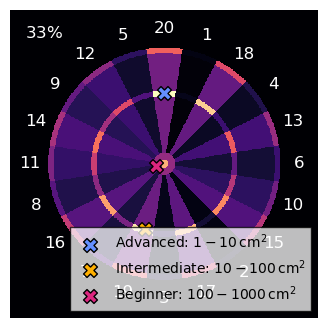

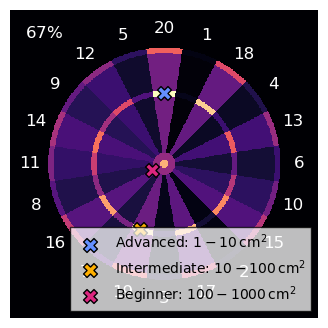

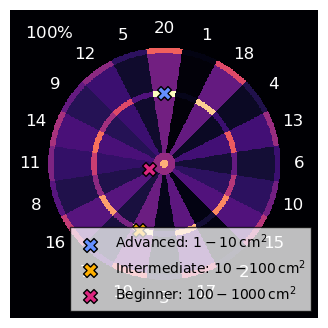

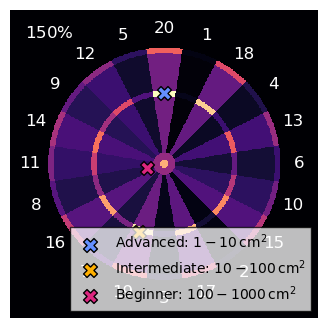

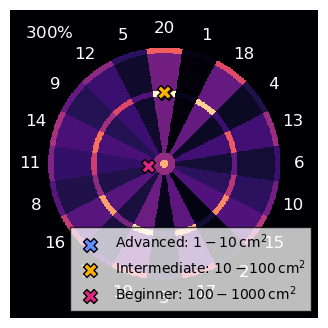

In [11]:
area_skill_50 = (1e-4, 10e-4, 100e-4, 1000e-4)

is_advanced = (area_skill_50[0] <= area_50) & (area_50 < area_skill_50[1])
is_intermediate = (area_skill_50[1] <= area_50) & (area_50 < area_skill_50[2])
is_beginner = (area_skill_50[2] <= area_50) & (area_50 < area_skill_50[3])

for jj in range(len(scales)):
    optimal_index_advanced = np.argmax(np.mean(points_expected[:, :, is_advanced, jj], axis=2))
    optimal_index_advanced = np.unravel_index(optimal_index_advanced, points_expected.shape[:2])
    x_opt_adv = x_g[optimal_index_advanced]
    y_opt_adv = y_g[optimal_index_advanced]
    
    optimal_index_intermediate = np.argmax(np.mean(points_expected[:, :, is_intermediate, jj], axis=2))
    optimal_index_intermediate = np.unravel_index(optimal_index_intermediate, points_expected.shape[:2])
    x_opt_int = x_g[optimal_index_intermediate]
    y_opt_int = y_g[optimal_index_intermediate]
    
    optimal_index_beginner = np.argmax(np.mean(points_expected[:, :, is_beginner, jj], axis=2))
    optimal_index_beginner = np.unravel_index(optimal_index_beginner, points_expected.shape[:2])
    x_opt_beg = x_g[optimal_index_beginner]
    y_opt_beg = y_g[optimal_index_beginner]

    plt.figure(figsize=(4, 4))

    plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")
    
    plt.scatter(x_opt_adv, y_opt_adv, color=blue, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Advanced: $1 - 10\,\\text{{cm}}^2$", zorder=10)
    plt.scatter(x_opt_int, y_opt_int, color=yellow, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Intermediate: $10 - 100\,\\text{{cm}}^2$", zorder=15)
    plt.scatter(x_opt_beg, y_opt_beg, color=red, edgecolor=(0, 0, 0), marker="X", s=100, label=f"Beginner: $100 - 1000\,\\text{{cm}}^2$", zorder=20)
           
    plt.text(0.05, 0.95, f"${100 * scales[jj]:.0f}\%$", 
             horizontalalignment="left",
             verticalalignment="top",
             color=(1, 1, 1),
             fontsize=12,
             transform=plt.gca().transAxes,
             zorder=10)
    
    for ii in range(len(points_order)):
        plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
                 points_order[ii], 
                 horizontalalignment="center",
                 verticalalignment="center",
                 fontsize=12, 
                 color=(1, 1, 1))
    
    plt.gca().axis("off")
    plt.gca().set_aspect(1)
    legend = plt.legend(loc="lower right", fancybox=False, edgecolor=(0, 0, 0), framealpha=0.75, ncol=1)
    legend.set_zorder(25)
    
    plt.savefig(Path("..", "content", "img", f"optimal_average_strategy_s{100 * scales[jj]:.0f}%.svg"), dpi=600)
    # plt.close()